Author: Paulina Pojda

This notebook models the transport of a substance—like heat, pollutants, or nutrients—through a medium (e.g., air or water) where both advection and diffusion occur.

A typical real-world example is the dispersion of a pollutant in a river, where the flow of water carries the substance downstream (advection), while it also spreads out due to molecular mixing (diffusion).

By solving the advection-diffusion equation numerically and comparing it to an analytical solution, we can evaluate how well the numerical scheme captures this physical process under various conditions.

In [1]:
import numpy as np
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
from open_atmos_jupyter_utils import show_plot, show_anim

In [2]:
class PsiAnalytic:
    def __init__(self, *, mu, L):
        self.mu = mu
        self.L = L
    def __call__(self, *, x, t):
        return np.exp(-self.mu * t * (np.pi / self.L)**2) * np.sin(np.pi * x / self.L)

In [3]:
psi_analytic = PsiAnalytic(mu=.5, L=10)
nx = 64
x, dx = np.linspace(0, 10, nx+1, endpoint=True, retstep=True)
x = x[:-1] + dx/2
t_max = 10

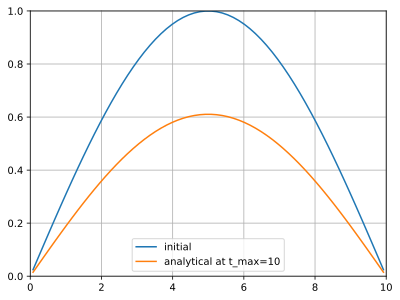

In [4]:
pyplot.plot(x, psi_analytic(x=x,t=0), label='initial')
pyplot.plot(x, psi_analytic(x=x,t=t_max), label=f'analytical at {t_max=}')
pyplot.xlim(0, psi_analytic.L)
pyplot.ylim(0, 1)
pyplot.legend()
pyplot.grid()
show_plot('analytic.pdf')

In [5]:
def F(psi_l, psi_r, C):
    return .5 * (C + abs(C)) * psi_l + \
           .5 * (C - abs(C)) * psi_r

class shift:
    def __init__(self, *, add, sub):
        self.add = add
        self.sub = sub
    def __radd__(self, i): 
        return slice(i.start + self.add, i.stop + self.add)
    def __rsub__(self, i): 
        return slice(i.start - self.sub, i.stop - self.sub)

In [6]:
nt = 600
u = 0.1
dt = t_max/nt
one = shift(add=1, sub=1)
hlf = shift(add=0, sub=1)
i = slice(1, nx-1)
im = slice(1, nx)

In [7]:
psi = psi_analytic(x=x, t = 0)
C = u * dt/dx
for _ in range(nt):
    psi[i] = psi[i] - (F(psi[i], psi[i+one], C) - F(psi[i-one], psi[i], C))

C = np.zeros(len(psi) - 1)
output = [psi.copy()]
for _ in range(nt):
    C[im - hlf] = -2 * psi_analytic.mu * dt / dx**2 * (psi[im] - psi[im - one]) / (psi[im - one] + psi[im])
    assert max(abs(C)) <= 1 
    psi[i] = psi[i] - (
        F(psi[i      ], psi[i + one], C[i + hlf]) -
        F(psi[i - one], psi[i      ], C[i - hlf]) 
    )
    output += [psi.copy()]

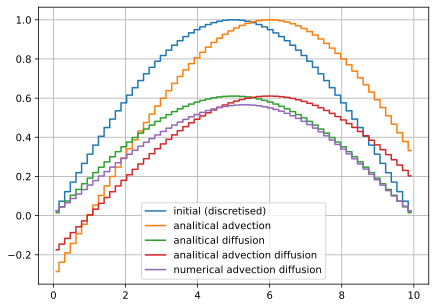

In [8]:
fig = pyplot.figure(figsize=(7,5))

pyplot.step(x, psi_analytic(x=x, t = 0), label='initial (discretised)', where='mid')
pyplot.step(x, psi_analytic(x=x - u * t_max, t = 0), label='analitical advection', where='mid')
pyplot.step(x, psi_analytic(x=x, t=nt*dt), label='analitical diffusion', where='mid')
pyplot.step(x, psi_analytic(x=x - u * t_max, t=nt*dt), label='analitical advection diffusion', where='mid')
pyplot.step(x, output[nt], label='numerical advection diffusion', where='mid')
pyplot.legend()
pyplot.grid()
show_plot(fig=fig)

In [9]:
numerical = output[nt]
analitical = psi_analytic(x=x - u * t_max, t=nt*dt)
mean_squared_error(numerical, analitical)**(1/2)

0.11997198854260531

The plot shows that the numerical solution is close to the analytical advection-diffusion result but is a bit smoother and lower at the peak. This means the method adds some artificial diffusion. Overall, the method slightly reduces accuracy due to the way it's computed, as expected.